<a href="https://colab.research.google.com/github/muhammad-usama-aleem/Model-from-Scratch/blob/main/ResNet_20_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
    ])

    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    print(split)

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# CIFAR10 dataset
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=256)

test_loader = data_loader(data_dir='./data',
                              batch_size=256,
                              test=True)

Files already downloaded and verified
Files already downloaded and verified
5000
Files already downloaded and verified


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))


        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
!pip install fastbook
from fastbook import *

In [ ]:
path = untar_data(URLs.MNIST)

mnist = DataBlock(blocks = (ImageBlock,CategoryBlock),
                 get_items = get_image_files,
                 get_y = parent_label,
                 splitter = RandomSplitter(valid_pct = 0.2, seed = 42))

dsets = mnist.dataloaders(path/'training')

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593

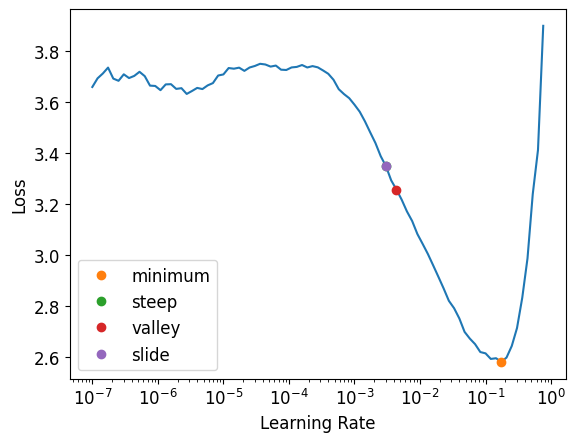

In [ ]:
learn = cnn_learner(dsets,resnet34,metrics=error_rate)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
num_classes = 10
num_epochs = 15
learning_rate = 0.05

model = ResNet(ResidualBlock, [2, 2, 3, 2]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)

# Train the model
total_step = len(train_loader)

In [ ]:
if torch.cuda.is_available():
    model.cuda()
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [ ]:
import gc
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

100%|██████████| 176/176 [04:55<00:00,  1.68s/it]


Epoch [1/15], Loss: 1.3161
Accuracy of the network on the 5000 validation images: 51.16 %


100%|██████████| 176/176 [04:50<00:00,  1.65s/it]


Epoch [2/15], Loss: 1.0413
Accuracy of the network on the 5000 validation images: 65.3 %


100%|██████████| 176/176 [04:48<00:00,  1.64s/it]


Epoch [3/15], Loss: 0.8367
Accuracy of the network on the 5000 validation images: 72.58 %


100%|██████████| 176/176 [04:47<00:00,  1.63s/it]


Epoch [4/15], Loss: 0.5819
Accuracy of the network on the 5000 validation images: 76.72 %


100%|██████████| 176/176 [04:45<00:00,  1.62s/it]


Epoch [5/15], Loss: 0.5502
Accuracy of the network on the 5000 validation images: 78.84 %


100%|██████████| 176/176 [04:47<00:00,  1.64s/it]


Epoch [6/15], Loss: 0.4607
Accuracy of the network on the 5000 validation images: 80.58 %


100%|██████████| 176/176 [04:49<00:00,  1.65s/it]


Epoch [7/15], Loss: 0.3752
Accuracy of the network on the 5000 validation images: 81.02 %


100%|██████████| 176/176 [04:50<00:00,  1.65s/it]


Epoch [8/15], Loss: 0.4360
Accuracy of the network on the 5000 validation images: 81.34 %


100%|██████████| 176/176 [04:48<00:00,  1.64s/it]


Epoch [9/15], Loss: 0.2339
Accuracy of the network on the 5000 validation images: 81.7 %


100%|██████████| 176/176 [04:48<00:00,  1.64s/it]


Epoch [10/15], Loss: 0.3313
Accuracy of the network on the 5000 validation images: 81.7 %


100%|██████████| 176/176 [04:47<00:00,  1.63s/it]


Epoch [11/15], Loss: 0.2044
Accuracy of the network on the 5000 validation images: 82.94 %


100%|██████████| 176/176 [04:48<00:00,  1.64s/it]


Epoch [12/15], Loss: 0.1495
Accuracy of the network on the 5000 validation images: 83.08 %


100%|██████████| 176/176 [04:46<00:00,  1.63s/it]


Epoch [13/15], Loss: 0.1381
Accuracy of the network on the 5000 validation images: 83.0 %


100%|██████████| 176/176 [04:47<00:00,  1.63s/it]


Epoch [14/15], Loss: 0.1122
Accuracy of the network on the 5000 validation images: 83.48 %


100%|██████████| 176/176 [04:45<00:00,  1.62s/it]


Epoch [15/15], Loss: 0.0841
Accuracy of the network on the 5000 validation images: 82.62 %


In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 81.93 %
